## `LangGraph` based calculator for running calculation for two quantities.
----

### Imports

In [1]:
import os
import openai
import getpass
from dotenv import load_dotenv, find_dotenv

In [2]:
# Cell 1: Install LangGraph and LangChain if not installed
# !pip install langgraph langchain openai --quiet

# Cell 2: Imports
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langchain_core.runnables import Runnable
from typing import TypedDict, Annotated
from langchain_openai import ChatOpenAI
import operator

In [3]:
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage,ToolMessage, AIMessage
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.schema import HumanMessage
from langchain_core.tools import tool

### Defining Supervisor
- This acts as a router for user query. It can decide which node to chose next based on the user's query.
- This is a langchain object. It consists of `llm`, `prompt` and `output_parser`.
- Every component above is combined and a single `langhchain` object is created.

In [4]:
OPENAI_API_KEY= ''

In [5]:
llm = ChatOpenAI(model="gpt-4o-mini",api_key = OPENAI_API_KEY)  #reduce inference cost

In [6]:
# Define the members (agent descriptions)
members = [
    {
        "agent_name": "add",
        "description": "Performs addition of two numbers. Input should be two comma-separated values, e.g., '5,7'."
    },
    {
        "agent_name": "subtract",
        "description": "Performs subtraction of two numbers. Input should be two comma-separated values, e.g., '10,3' means 10 - 3."
    },
    {
        "agent_name": "multiply",
        "description": "Performs multiplication of two numbers. Input should be two comma-separated values, e.g., '4,6'."
    },
    {
        "agent_name": "divide",
        "description": "Performs division of two numbers. Input should be two comma-separated values, e.g., '12,4' means 12 / 4."
    },
    {
        "agent_name": "exponent",
        "description": "Performs exponentiation. Raises the first number to the power of the second. Input format: '2,3' means 2^3 = 8."
    }
]


In [7]:
options = ["FINISH"] + [mem['agent_name'] for mem in members]

In [8]:
prompt = """
You are a smart assistant capable of helping with basic arithmetic operations using specialized tools. 
You have access to the following tools:

- `add`: adds two numbers.
- `subtract`: subtracts the second number from the first.
- `multiply`: multiplies two numbers.
- `divide`: divides the first number by the second.
- `exponent`: raises the first number to the power of the second.

When a user asks a question, identify the correct tool and extract exactly two numeric values from the input. 
Pass those values as a comma-separated string to the appropriate tool (e.g., "5,3").
Try to go through the conversation information provided by the user in input, and if you think solution is
already available use `direct_response` to proivde the answer and chose to route to `FINISH`.

Always prefer using the tool's response over your own response.
If the user query does not require any calculation, do not respond and finish the conversation.
"""




In [9]:
# Define the prompt with placeholders for variables
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", prompt.strip()),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [10]:
# Define the function schema for routing based on updated AgentState
function_def = {
    "name": "route",
    "description": "Select the next tool to use and optionally pass arguments.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "description": "Name of the next node/tool to call based on the user query.",
                "type": "string",
                "enum": options  # e.g., ["add", "subtract", "multiply", "divide", "exponent", "FINISH"]
            },
            "num_1": {
                "type": "number",
                "description": "The first numeric argument extracted from the user's query."
            },
            "num_2": {
                "type": "number",
                "description": "The second numeric argument extracted from the user's query."
            },
            "ans": {
                "type": "number",
                "description": "Optional. If you are able to compute the answer directly, provide it here.",
            },
            "thought_process": {
                "type": "string",
                "description": "1–5 bullet points explaining your reasoning before choosing the tool or answer."
            },
            "direct_response": {
                "type": "string",
                "description": "Optional. Your direct natural language response to the user if no tool is needed."
            }
        },
        "required": ["next", "num_1", "num_2"]
    }
}


In [11]:
supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)


/var/folders/0h/w2x5g9nd77x9s1fk2h7qj9980000gp/T/ipykernel_44343/1653979275.py:3: LangChainDeprecationWarning: The method `BaseChatOpenAI.bind_functions` was deprecated in langchain-openai 0.2.1 and will be removed in 1.0.0. Use :meth:`~langchain_openai.chat_models.base.ChatOpenAI.bind_tools` instead.
  | llm.bind_functions(functions=[function_def], function_call="route")


In [12]:
# Invoking `supervisor_chain`
supervisor_chain.invoke([HumanMessage(content="What is the sum of 10 and 30?",name='Human')])

{'next': 'add', 'num_1': 10, 'num_2': 30}

- Our `supervisor_chain` is working fine as per our expectation. It is correctly identifying the arguments and next node to route to.

--------
### Creating our workflow

- `Nodes` : Agents or functions
- `Edges` : connect nodes
- `Conditional Edges` : decisions, about which nodes to go to next



- In this workflow a `supervisor` node is connected to various nodes `add`,`subtract`, `multiply`, `divide` and `exponent`.
- Based on the user's query, the `supervisor` can decide which node to use in order to answer the question.

#### Agent State/ Data

- Agent State is accessible to all parts of the graph
- It is local to the graph
- Can be stored in the persistence layer, meaning that we can resume with that state at any point in time later on.

In [13]:
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]
    num_1 : float
    num_2 : float
    ans : float
    next : str

In [14]:
# 📌 Supervisor Node (LLM routing logic)
def supervisor_node(state: AgentState,chain=supervisor_chain) -> dict:
    
    all_msg=""
    for msg in state['messages']:
        role = "Human" if msg.name is None else msg.name
        info = msg.content
        all_msg += f"\n{role} :{info}."
    
    
    result = supervisor_chain.invoke([HumanMessage(content=all_msg)])
    
    
    if result['next']=='FINISH':
        message = result.get('direct_response',"Routing to `FINISH`.")
        
        return {
            "next": result['next'],
            "messages":[HumanMessage(content=message,name='supervisor')]
        }
        

    message = result.get('direct_response', result.get("thought_process",""))
    message = "".join(message) if type(message)==list else message
    
    
    return {"next": result['next'],
            "messages":[HumanMessage(content=message,name='supervisor')],
            "num_1":result.get('num_1',state.get('num_1',None)),
            "num_2":result.get('num_2',state.get('num_2',None)),
            "ans":result.get('num_2',state.get('ans',None))}


In [15]:
# New operation-specific nodes
def add_node(state: AgentState) -> AgentState:
    msg = state["messages"][-1].content
    try:
        a, b = state.get('num_1',None),state.get('num_2',None)
        ans = a + b
        response = f"Addition result: {ans}"
    except Exception as e:
        response = f"Error in add_node: {str(e)}"
        ans = None
    return {"ans": ans,"messages": [AIMessage(content=response,name='add')],"next":"supervisor"}

def subtract_node(state: AgentState) -> AgentState:
    msg = state["messages"][-1].content
    try:
        a, b = state.get('num_1',None),state.get('num_2',None)
        ans = a - b
        response = f"Subtraction result: {ans}"
    except Exception as e:
        response = f"Error in subtract_node: {str(e)}"
        ans = None
    return {"ans":ans,"messages": [AIMessage(content=response,name='subtract')],"next":"supervisor"}

def multiply_node(state: AgentState) -> AgentState:
    msg = state["messages"][-1].content
    try:
        a, b = state.get('num_1',None),state.get('num_2',None)
        ans = a * b
        response = f"Multiplication result: {ans}"
    except Exception as e:
        response = f"Error in multiply_node: {str(e)}"
        ans = None
    return {"ans":ans,"messages": [AIMessage(content=response,name='multiply')],"next":"supervisor"}

def divide_node(state: AgentState) -> AgentState:
    msg = state["messages"][-1].content
    try:
        a, b = state.get('num_1',None),state.get('num_2',None)
        ans = a / b
        response = f"Division result: {ans}"
    except Exception as e:
        response = f"Error in divide_node: {str(e)}"
        ans = None
    return {"ans":ans,"messages": [AIMessage(content=response,name='divide')],"next":"supervisor"}

def exponent_node(state: AgentState) -> AgentState:
    msg = state["messages"][-1].content
    try:
        a, b = state.get('num_1',None),state.get('num_2',None)
        ans = a ** b
        response = f"Exponentiation result: {ans}"
    except Exception as e:
        response = f"Error in exponent_node: {str(e)}"
        ans = None
    return {"ans":ans,"messages": [AIMessage(content=response,name='exponent')],"next":"supervisor"}


In [16]:
# Build LangGraph with new nodes
graph_builder = StateGraph(AgentState)

graph_builder.add_node("supervisor", supervisor_node)
graph_builder.add_node("add", add_node)
graph_builder.add_node("subtract", subtract_node)
graph_builder.add_node("multiply", multiply_node)
graph_builder.add_node("divide", divide_node)
graph_builder.add_node("exponent", exponent_node)

graph_builder.set_entry_point("supervisor")
graph_builder.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "add": "add",
        "subtract": "subtract",
        "multiply": "multiply",
        "divide": "divide",
        "exponent": "exponent",
        "FINISH": END,
    },
)
graph_builder.add_edge("add", "supervisor")
graph_builder.add_edge("subtract", "supervisor")
graph_builder.add_edge("multiply", "supervisor")
graph_builder.add_edge("divide", "supervisor")
graph_builder.add_edge("exponent", "supervisor")

graph = graph_builder.compile()


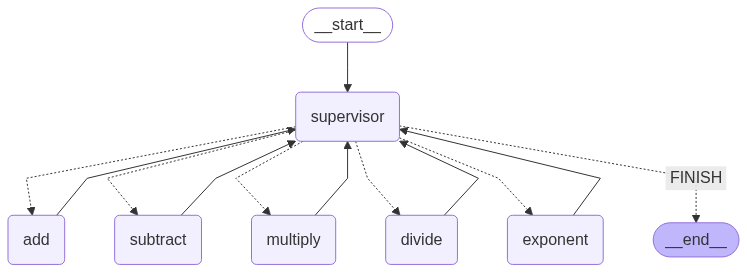

In [17]:
graph

- The above `graph` variable stores the langgraph object, which stores the above defined workflow.
- Any query we pass to `graph`, will be processed accordingly.

-------
### Example using `stream` method

In [18]:
question = """Calculate price of 13.5 oranges if cost of 1 orange is 10Rs, later find how many apples I can buy in
that amount if cost of one apple is 17Rs."""

In [19]:
print("Human",question,sep=": ")
print('\n')
state = {"messages":[HumanMessage(content=question)],"next":"supervisor"}

for s in graph.stream(state):
    print(s)

Human: Calculate price of 13.5 oranges if cost of 1 orange is 10Rs, later find how many apples I can buy in
that amount if cost of one apple is 17Rs.


{'supervisor': {'next': 'multiply', 'messages': [HumanMessage(content='', additional_kwargs={}, response_metadata={}, name='supervisor', id='3056cee9-6870-4e80-aa89-fc5b5cc5c1b7')], 'num_1': 13.5, 'num_2': 10, 'ans': 10}}
{'multiply': {'ans': 135.0, 'messages': [AIMessage(content='Multiplication result: 135.0', additional_kwargs={}, response_metadata={}, name='multiply', id='062a0505-5552-42da-aa03-94e3f7d6c268')], 'next': 'supervisor'}}
{'supervisor': {'next': 'divide', 'messages': [HumanMessage(content='You can buy approximately 7.94 apples with the amount from selling 13.5 oranges.', additional_kwargs={}, response_metadata={}, name='supervisor', id='8678cdfd-60d2-4ac5-a2e2-a8d365750cda')], 'num_1': 135, 'num_2': 17, 'ans': 17}}
{'divide': {'ans': 7.9411764705882355, 'messages': [AIMessage(content='Division result: 7.9411764705882355'

-------
### Beautifying the print for `stream`

In [20]:
def pretty_print_stream(stream):
    for step in stream:
        for role, output in step.items():
            print(f"\n🧠 Step: {role.upper()}")

            # Check if it's a dict with 'messages' (AgentState)
            if isinstance(output, dict) and "messages" in output:
                for msg in output["messages"]:
                    if isinstance(msg, HumanMessage):
                        print(f"👤 Human: {msg.content}")
                    elif isinstance(msg, AIMessage):
                        print(f"🤖 {role.capitalize()}: {msg.content}")
                    else:
                        print(f"🔹 Message: {msg.content}")
            
            # Print additional keys like num_1, num_2, ans
            for k, v in output.items():
                if k not in ["messages"]:
                    print(f"🔸 {k}: {v}")

In [21]:
print("Human",question,sep=": ")
print('\n')

state = {"messages":[HumanMessage(content=question)],"next":"supervisor"}

Human: Calculate price of 13.5 oranges if cost of 1 orange is 10Rs, later find how many apples I can buy in
that amount if cost of one apple is 17Rs.




In [22]:
stream = graph.stream(state)
pretty_print_stream(stream)


🧠 Step: SUPERVISOR
👤 Human: The problem asks to calculate the price of 13.5 oranges.Each orange costs 10 Rs.Multiplying the number of oranges by the cost of each will give the total price for oranges.Therefore, I will use the multiply tool with 13.5 and 10.
🔸 next: multiply
🔸 num_1: 13.5
🔸 num_2: 10
🔸 ans: 10

🧠 Step: MULTIPLY
🤖 Multiply: Multiplication result: 135.0
🔸 ans: 135.0
🔸 next: supervisor

🧠 Step: SUPERVISOR
👤 Human: 
🔸 next: divide
🔸 num_1: 135
🔸 num_2: 17
🔸 ans: 17

🧠 Step: DIVIDE
🤖 Divide: Division result: 7.9411764705882355
🔸 ans: 7.9411764705882355
🔸 next: supervisor

🧠 Step: SUPERVISOR
👤 Human: You can buy approximately 7.94 apples with the amount for 13.5 oranges.
🔸 next: FINISH


-------
### Example using `manual` stepwise invoke for each node

In [23]:
def update_state(state: dict, current_state: dict) -> dict:
    """
    Updates `state` with values from `current_state`.
    - Merges 'messages' using LangGraph's `add_messages`
    - Updates existing keys or adds new keys
    """
    for key, value in current_state.items():
        if key == "messages":
            state["messages"] = add_messages(state.get("messages", []), value)
        else:
            state[key] = value
    return state

In [24]:
print("Human",question,sep=": ")
print('\n')

state = {"messages":[HumanMessage(content=question)],"next":"supervisor"}

Human: Calculate price of 13.5 oranges if cost of 1 orange is 10Rs, later find how many apples I can buy in
that amount if cost of one apple is 17Rs.




In [25]:
current_state= graph.nodes[state['next']].invoke(state)
current_state

{'next': 'multiply',
 'messages': [HumanMessage(content='', additional_kwargs={}, response_metadata={}, name='supervisor')],
 'num_1': 13.5,
 'num_2': 10,
 'ans': 10}

In [26]:
state = update_state(state,current_state)
state

{'messages': [HumanMessage(content='Calculate price of 13.5 oranges if cost of 1 orange is 10Rs, later find how many apples I can buy in\nthat amount if cost of one apple is 17Rs.', additional_kwargs={}, response_metadata={}, id='a46ca433-87e8-4464-b973-46afe2c6a3c2'),
  HumanMessage(content='', additional_kwargs={}, response_metadata={}, name='supervisor', id='ff39a3d2-6f49-4df7-9e08-9c1e7f092c3e')],
 'next': 'multiply',
 'num_1': 13.5,
 'num_2': 10,
 'ans': 10}

In [27]:
current_state= graph.nodes[state['next']].invoke(state)
current_state

{'ans': 135.0,
 'messages': [AIMessage(content='Multiplication result: 135.0', additional_kwargs={}, response_metadata={}, name='multiply')],
 'next': 'supervisor'}

In [28]:
state = update_state(state,current_state)
state

{'messages': [HumanMessage(content='Calculate price of 13.5 oranges if cost of 1 orange is 10Rs, later find how many apples I can buy in\nthat amount if cost of one apple is 17Rs.', additional_kwargs={}, response_metadata={}, id='a46ca433-87e8-4464-b973-46afe2c6a3c2'),
  HumanMessage(content='', additional_kwargs={}, response_metadata={}, name='supervisor', id='ff39a3d2-6f49-4df7-9e08-9c1e7f092c3e'),
  AIMessage(content='Multiplication result: 135.0', additional_kwargs={}, response_metadata={}, name='multiply', id='5519a216-9790-4dbc-9ea1-83e6e97b6cee')],
 'next': 'supervisor',
 'num_1': 13.5,
 'num_2': 10,
 'ans': 135.0}

In [29]:
current_state= graph.nodes[state['next']].invoke(state)
current_state

{'next': 'divide',
 'messages': [HumanMessage(content='You can buy a certain number of apples with the amount from the oranges.', additional_kwargs={}, response_metadata={}, name='supervisor')],
 'num_1': 135,
 'num_2': 17,
 'ans': 17}

In [30]:
state = update_state(state,current_state)
state

{'messages': [HumanMessage(content='Calculate price of 13.5 oranges if cost of 1 orange is 10Rs, later find how many apples I can buy in\nthat amount if cost of one apple is 17Rs.', additional_kwargs={}, response_metadata={}, id='a46ca433-87e8-4464-b973-46afe2c6a3c2'),
  HumanMessage(content='', additional_kwargs={}, response_metadata={}, name='supervisor', id='ff39a3d2-6f49-4df7-9e08-9c1e7f092c3e'),
  AIMessage(content='Multiplication result: 135.0', additional_kwargs={}, response_metadata={}, name='multiply', id='5519a216-9790-4dbc-9ea1-83e6e97b6cee'),
  HumanMessage(content='You can buy a certain number of apples with the amount from the oranges.', additional_kwargs={}, response_metadata={}, name='supervisor', id='13930f00-dfa6-4ba4-b92e-1f3723809f7d')],
 'next': 'divide',
 'num_1': 135,
 'num_2': 17,
 'ans': 17}

In [31]:
current_state= graph.nodes[state['next']].invoke(state)
current_state

{'ans': 7.9411764705882355,
 'messages': [AIMessage(content='Division result: 7.9411764705882355', additional_kwargs={}, response_metadata={}, name='divide')],
 'next': 'supervisor'}

In [32]:
state = update_state(state,current_state)
state

{'messages': [HumanMessage(content='Calculate price of 13.5 oranges if cost of 1 orange is 10Rs, later find how many apples I can buy in\nthat amount if cost of one apple is 17Rs.', additional_kwargs={}, response_metadata={}, id='a46ca433-87e8-4464-b973-46afe2c6a3c2'),
  HumanMessage(content='', additional_kwargs={}, response_metadata={}, name='supervisor', id='ff39a3d2-6f49-4df7-9e08-9c1e7f092c3e'),
  AIMessage(content='Multiplication result: 135.0', additional_kwargs={}, response_metadata={}, name='multiply', id='5519a216-9790-4dbc-9ea1-83e6e97b6cee'),
  HumanMessage(content='You can buy a certain number of apples with the amount from the oranges.', additional_kwargs={}, response_metadata={}, name='supervisor', id='13930f00-dfa6-4ba4-b92e-1f3723809f7d'),
  AIMessage(content='Division result: 7.9411764705882355', additional_kwargs={}, response_metadata={}, name='divide', id='63c1ca85-4563-4bb7-b1d4-cd7370472b6d')],
 'next': 'supervisor',
 'num_1': 135,
 'num_2': 17,
 'ans': 7.94117647

In [33]:
current_state= graph.nodes[state['next']].invoke(state)
current_state

{'next': 'FINISH',
 'messages': [HumanMessage(content='You can buy approximately 7 apples with the amount from selling 13.5 oranges.', additional_kwargs={}, response_metadata={}, name='supervisor')]}

-------
#### The END..!


------